In [1]:
import pandas as pd

df = pd.read_csv('/content/credit_risk_dataset.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [2]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
df.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


In [4]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [5]:
df['loan_status'].value_counts()

,count
loan_status,
0,25473
1,7108


In [6]:
from sklearn.impute import SimpleImputer

# Identify numeric columns with missing data
missing_cols = df.columns[df.isnull().any()].tolist()
print("Columns with missing values:", missing_cols)

# Apply median imputation to these columns
imputer = SimpleImputer(strategy='median')
df[missing_cols] = imputer.fit_transform(df[missing_cols])

# Verify all missing values are gone
print("Missing values after imputation:")
print(df.isnull().sum())


Columns with missing values: ['person_emp_length', 'loan_int_rate']
Missing values after imputation:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [7]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [8]:
from imblearn.over_sampling import SMOTE

X = df.drop('loan_status', axis=1)
y = df['loan_status']

# SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts())

Class distribution after SMOTE:
loan_status
1    25473
0    25473
Name: count, dtype: int64


In [9]:
import numpy as np

# Add Debt-to-Income Ratio if not already present
if 'loan_percent_income' not in X_res.columns:
    X_res['loan_percent_income'] = X_res['loan_amnt'] / X_res['person_income']

# Employment length buckets
X_res['emp_length_bucket'] = pd.cut(X_res['person_emp_length'], bins=[0, 2, 5, 10, 20, 50], labels=False)

# Age group bucket
X_res['age_group'] = pd.cut(X_res['person_age'], bins=[18, 25, 35, 45, 55, 65, 80], labels=False)

print("Feature engineered sample:")
X_res.head()


Feature engineered sample:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,emp_length_bucket,age_group
0,22,59000,3,123.0,4,3,35000,16.02,0.59,1,3,NaN,0.0
1,21,9600,2,5.0,1,1,1000,11.14,0.10,0,2,1.0,0.0
2,25,9600,0,1.0,3,2,5500,12.87,0.57,0,3,0.0,0.0
3,23,65500,3,4.0,3,2,35000,15.23,0.53,0,2,1.0,0.0
4,24,54400,3,8.0,3,2,35000,14.27,0.55,1,4,2.0,0.0


In [10]:
# Add Debt-to-Income Ratio if not already present
if 'loan_percent_income' not in X_res.columns:
    # Ensure person_income is not zero to avoid division by zero
    X_res['loan_percent_income'] = X_res['loan_amnt'] / X_res['person_income'].replace(0, np.nan)

# Employment length buckets
# Handle potential NaNs in person_emp_length before cutting
X_res['emp_length_bucket'] = pd.cut(X_res['person_emp_length'], bins=[0, 2, 5, 10, 20, 50], labels=False, include_lowest=True)

# Age group bucket
# Handle potential NaNs in person_age before cutting
X_res['age_group'] = pd.cut(X_res['person_age'], bins=[18, 25, 35, 45, 55, 65, 80], labels=False, include_lowest=True)

print("Feature engineered sample:")
X_res.head()

# Check for NaNs after feature engineering
print("\nChecking for NaNs after feature engineering:")
print(X_res.isnull().sum()[X_res.isnull().sum() > 0])

# Apply imputation again if needed after feature engineering
cols_with_na_after_engineering = X_res.columns[X_res.isnull().any()].tolist()
if cols_with_na_after_engineering:
    print(f"\nApplying imputation to columns with new NaNs after feature engineering: {cols_with_na_after_engineering}")
    imputer_post_fe = SimpleImputer(strategy='median')
    numeric_cols_to_impute = X_res[cols_with_na_after_engineering].select_dtypes(include=np.number).columns.tolist()
    if numeric_cols_to_impute:
         X_res[numeric_cols_to_impute] = imputer_post_fe.fit_transform(X_res[numeric_cols_to_impute])

print("\nMissing values after post-feature engineering imputation:")
print(X_res.isnull().sum().sum())

Feature engineered sample:

Checking for NaNs after feature engineering:
emp_length_bucket    2
age_group            7
dtype: int64

Applying imputation to columns with new NaNs after feature engineering: ['emp_length_bucket', 'age_group']

Missing values after post-feature engineering imputation:
0


In [11]:
# Proceed with train-test split and model fitting
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit models
print("\nFitting models...")
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
print("Models fitted successfully.")


Fitting models...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:42:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Models fitted successfully.


In [12]:
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [13]:
print("Any NaNs in X_train:", X_train.isnull().any().sum())
print("Columns with NaNs:\n", X_train.isnull().sum()[X_train.isnull().sum() > 0])

Any NaNs in X_train: 0
Columns with NaNs:
 Series([], dtype: int64)


In [14]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred))
    print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(gb, X_test, y_test, "Gradient Boosting")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      5095
           1       0.94      0.91      0.92      5095

    accuracy                           0.93     10190
   macro avg       0.93      0.93      0.93     10190
weighted avg       0.93      0.93      0.93     10190

AUC-ROC Score: 0.9784450494577511

=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5095
           1       0.93      0.87      0.90      5095

    accuracy                           0.90     10190
   macro avg       0.90      0.90      0.90     10190
weighted avg       0.90      0.90      0.90     10190

AUC-ROC Score: 0.9602721982046707

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5095
           1       0.98      0.92      0.95      5095

    accuracy                           0.95    

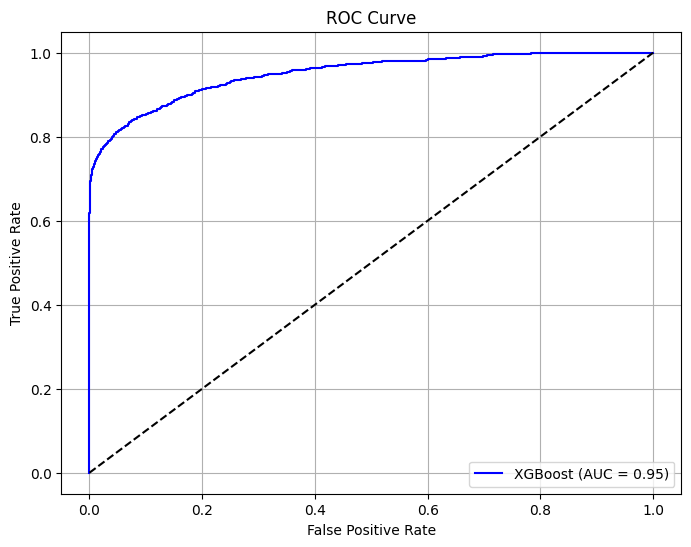

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
